In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

In [2]:
"""
These functions are versions of R functions in the R package DescTools by Andri Signorell
https://www.rdocumentation.org/packages/DescTools

The Boolean indexing for computing concordant and discordant pairs allows us to avoid testing
for indexing errors or writing special cases for the edges of a cross-tab matrix.

Still to Do:  Add options for confidence intervals.  We could also nest the row and col functions inside
to have them not visible in the surrounding environment.
"""
def row(ndarray):
    row_array = np.zeros_like(ndarray)
    nrow = ndarray.shape[0]
    for i in range(nrow):
        row_array[i,:] = i
    
    return row_array

def col(ndarray):
    col_array = np.zeros_like(ndarray)
    ncol = ndarray.shape[1]
    for j in range(ncol):
        col_array[:,j] = j
    
    return col_array

def concordant_discordant_pairs(cross_tab):
    shape = cross_tab.shape
    nrow = shape[0]
    ncol = shape[1]
    pi_c = np.zeros_like(cross_tab)
    pi_d = np.zeros_like(cross_tab)
    rowc = row(cross_tab)
    colc = col(cross_tab)
    
    for i in range(nrow):
        for j in range(ncol):
            # completely mimic R code - avoids testing for indexing errors
            # since a boolean index of all False will return an empty array
            # which sums to zero
            pi_c[i, j] = np.sum(cross_tab[np.logical_and(rowc < i, colc < j)]) +\
            np.sum(cross_tab[np.logical_and(rowc > i, colc > j)])
            pi_d[i, j] = np.sum(cross_tab[np.logical_and(rowc < i, colc > j)]) +\
            np.sum(cross_tab[np.logical_and(rowc > i, colc < j)])
            
    c = np.sum(np.multiply(pi_c, cross_tab)/2)
    d = np.sum(np.multiply(pi_d, cross_tab)/2)
    return pi_c, pi_d, c, d

def goodman_kruskall_gamma(x, y, conf_level=None):
    # this function could call the following function...
    cross_tab = pd.crosstab(x, y)
    return goodman_kruskall_gamma_from_crosstab(cross_tab.values, conf_level)

def goodman_kruskall_gamma_from_crosstab(table, conf_level=None):
    pi_C, pi_D, C, D = concordant_discordant_pairs(table)
    gamma = (C - D) / (C + D)
    if conf_level:
        psi = 2 * (D * pi_C - C * pi_D)/(C + D)**2
        sigma2 = np.sum(np.multiply(table, np.square(psi))) - np.sum(np.multiply(table, psi))**2
        pr2 = 1 - (1 - conf_level)/2
        ci = norm.ppf(pr2) * np.sqrt(sigma2) * np.array([-1, 1]) + gamma
        # print(np.sqrt(sigma2))
        return gamma, ci #, np.sqrt(sigma2), gamma / np.sqrt(sigma2) - leave this off for now
    else:
        return gamma

In [3]:
# Check that concordant_discordant_pairs() is working
x = np.array([[16, 8, 14], [19, 17, 60], [9, 11, 56]])
print(x)
_, _, conc_pairs, disc_pairs = concordant_discordant_pairs(x)
print(conc_pairs, disc_pairs)

[[16  8 14]
 [19 17 60]
 [ 9 11 56]]
5457.0 2361.0


In [4]:
# Compute Goodman Kruskall Gamma for a table and return confidence interval
table = np.array([[26,26,23,18, 9], [6, 7, 9,14, 23]])
goodman_kruskall_gamma_from_crosstab(table, conf_level=0.95)

(0.5313123254886318, array([0.34799183, 0.71463282]))

In [5]:
# Compute Goodman Kruskall Gamma for a table and return confidence interval
table = np.array([[15, 12, 6, 5], [12, 8, 10, 8], [4, 6, 9, 10]])
goodman_kruskall_gamma_from_crosstab(table, conf_level=0.95)

(0.34945848375451266, array([0.14322471, 0.55569225]))

In [6]:
# Compute Goodman Kruskall Gamma for a table and return confidence interval
goodman_kruskall_gamma_from_crosstab(table) # leaving conf_level unspecified skips the confidence interval

0.34945848375451266

In [8]:
# Consider a made-up ordinal dataframe
ord_df = pd.DataFrame({'x': np.random.randint(low=1,high=5,size=100),
                     'y': np.random.randint(low=1,high=5,size=100),
                     'z': np.random.randint(low=1,high=5,size=100)})
ord_df.head()

,x,y,z
0,2,4,3
1,2,1,1
2,1,1,1
3,2,3,1
4,1,1,3


In [9]:
ord_df.corr(method='kendall') # Kendall's tau is closely related to Goodman-Kruskall's gamma

,x,y,z
x,1.000000,0.042335,-0.090934
y,0.042335,1.000000,-0.053023
z,-0.090934,-0.053023,1.000000


In [10]:
goodman_kruskall_gamma(ord_df.x, ord_df.y, conf_level=0.95)

(0.056252239340738086, array([-0.15021721,  0.26272168]))

In [11]:
def goodman_corr_matrix(df, cols):
    """
    Given a Pandas DataFrame df and a list of columns in `cols`, calculates the Goodman-Kruskall 
    correlation matrix.  Returns the matrix as a DataFrame that can be plotted in seaborn's clustermap.
    """
    n = len(cols)
    corr_matrix = np.zeros((n,n))
    
    for i, col_i in enumerate(cols):
        for j, col_j in enumerate(cols):
            #print(df[col_i])
            corr_matrix[i, j] = goodman_kruskall_gamma(df[col_i].values, df[col_j].values)
            
    return pd.DataFrame(corr_matrix, columns=cols, index=cols)    

In [12]:
goodman_corr_matrix(ord_df, ['x', 'y', 'z', 'x', 'y'])

,x,y,z,x,y
x,1.000000,0.056252,-0.122093,1.000000,0.056252
y,0.056252,1.000000,-0.070201,0.056252,1.000000
z,-0.122093,-0.070201,1.000000,-0.122093,-0.070201
x,1.000000,0.056252,-0.122093,1.000000,0.056252
y,0.056252,1.000000,-0.070201,0.056252,1.000000


In [13]:
import seaborn as sns

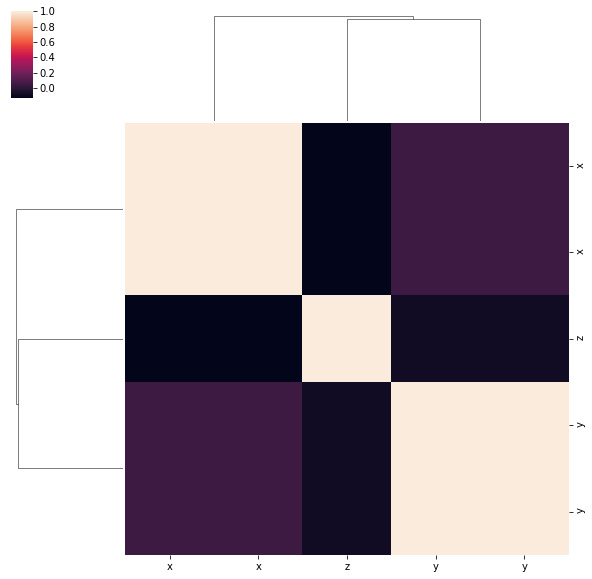

In [14]:
sns.clustermap(goodman_corr_matrix(ord_df, ['x', 'y', 'z', 'x', 'y']))

In [23]:
ord_df['x'].value_counts(sort=False)

1    23
2    22
3    33
4    22
Name: x, dtype: int64

In [26]:
def tabulate_ordinal_predictors(df, cols):
    
    # Do something to clear out NA's?
    n = len(cols)
    out_df = pd.DataFrame()
    
    for i, col_i in enumerate(cols):
        counts = df[col_i].value_counts(sort=False)
        out_df[col_i] = counts
        
    return out_df

In [27]:
tabulate_ordinal_predictors(ord_df, ['x', 'y', 'z'])

,x,y,z
1,23,31,31
2,22,19,30
3,33,23,22
4,22,27,17


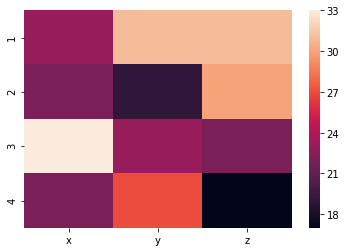

In [29]:
sns.heatmap(tabulate_ordinal_predictors(ord_df, ['x', 'y', 'z']))